# Prompting long 👀 Videos with Gemini 1.5 🔥🔥🔥

Une démo sur l'utilisation de plusieurs API de Google pour la génération automatique d'un transcript timé d'une vidéo.




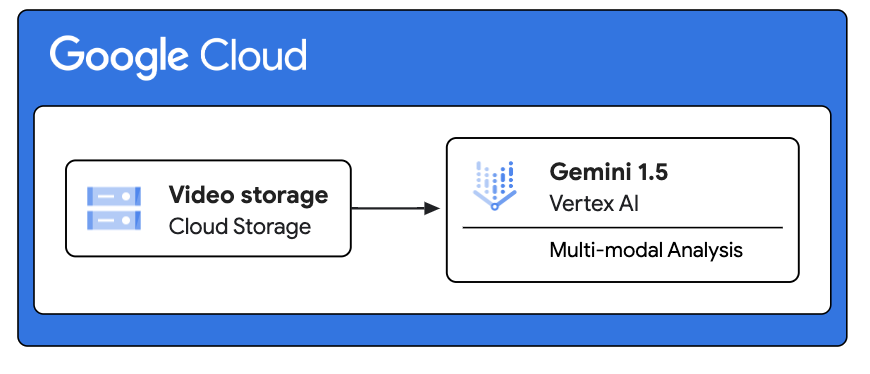


# -4) Seting up a venv in Vertex AI Workbench

Look at : https://cloud.google.com/vertex-ai/docs/workbench/instances/add-environment to create a python env

In [1]:
requirements_txt = """
google-cloud-aiplatform
varname
unidecode
pytube
google-cloud-videointelligence
moviepy
"""

In [2]:
shell_code = """

    myenv="gemini1.5" 
    
    conda create -n $myenv
    conda activate $myenv
    
    conda install pip
    pip install -r requirements.txt
    
# installting & creating the env : 
    DL_ANACONDA_ENV_HOME="${DL_ANACONDA_HOME}/envs/myenv"
    python -m ipykernel install --prefix "${DL_ANACONDA_ENV_HOME}" --name $myenv --display-name $myenv

#simlinking to vertex's default folder
    ln -s /opt/conda/envs/myenv/share/jupyter/kernels/$myenv ls /opt/conda/share/jupyter/kernels

"""# to execute as a shell command

# -3) Install python libraries

In [3]:
!pip install moviepy
!pip install varname
!pip install unidecode
!pip install pytube
!pip install google-cloud-videointelligence

  Using cached executing-2.0.1-py2.py3-none-any.whl.metadata (9.0 kB)
Using cached executing-2.0.1-py2.py3-none-any.whl (24 kB)
  Attempting uninstall: executing
    Found existing installation: executing 1.2.0
ERROR: Cannot uninstall executing 1.2.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps executing==1.2.0'.


# -2) import des librairies

In [4]:
"""Transcribe speech from a video stored on GCS."""

import vertexai
import json
import unidecode
import pandas as pd
import seaborn as sns
import base64

from google.cloud import storage
from google.cloud import videointelligence
from pytube import YouTube
from varname import nameof
from time import sleep
from moviepy.editor import VideoFileClip
from math import ceil

from IPython.display import Markdown, display
from sklearn.metrics.pairwise import cosine_similarity
from vertexai.generative_models import GenerativeModel

from vertexai.generative_models import Part, FinishReason

import vertexai.preview.generative_models as generative_models
from vertexai.preview.language_models import (ChatModel, InputOutputTextPair,
                                              TextEmbeddingModel,
                                              TextGenerationModel)



"""
Dans l'import from vertexai.generative_models import part, l'objet part représente une composante d'un modèle génératif Vertex AI. Il s'agit d'une unité de base qui peut être assemblée avec d'autres parties pour créer un modèle plus complexe.

Chaque partie possède ses propres fonctionnalités et caractéristiques, et peut être utilisée pour générer différents types de contenu. Voici quelques exemples de parties :

Texte: génère du texte, comme des phrases, des paragraphes ou des articles entiers.
Code: génère du code, comme des scripts Python ou des fonctions Java.
Image: génère des images, comme des photos ou des illustrations.
Audio: génère du son, comme de la musique ou des voix.
En plus de ces types de base, il existe également des parties plus spécialisées qui peuvent être utilisées pour des tâches spécifiques, comme la traduction, la synthèse de discours ou la génération de questions/réponses.
"""



"\nDans l'import from vertexai.generative_models import part, l'objet part représente une composante d'un modèle génératif Vertex AI. Il s'agit d'une unité de base qui peut être assemblée avec d'autres parties pour créer un modèle plus complexe.\n\nChaque partie possède ses propres fonctionnalités et caractéristiques, et peut être utilisée pour générer différents types de contenu. Voici quelques exemples de parties :\n\nTexte: génère du texte, comme des phrases, des paragraphes ou des articles entiers.\nCode: génère du code, comme des scripts Python ou des fonctions Java.\nImage: génère des images, comme des photos ou des illustrations.\nAudio: génère du son, comme de la musique ou des voix.\nEn plus de ces types de base, il existe également des parties plus spécialisées qui peuvent être utilisées pour des tâches spécifiques, comme la traduction, la synthèse de discours ou la génération de questions/réponses.\n"

# -1) Helper functions for bucket management

## -1.1) Managing buckets

In [5]:
def list_buckets_names():
    storage_client = storage.Client()
    buckets        = storage_client.list_buckets()
    return [bucket.name for bucket in buckets]

In [6]:
def create_bucket_class_location(bucket_name, storage_class = "STANDARD", location="us"):
    storage_client       = storage.Client()
    bucket               = storage_client.bucket(bucket_name)
    bucket.storage_class = storage_class
    new_bucket           = storage_client.create_bucket(bucket, location=location)
    print(f"Created bucket {new_bucket.name} in {new_bucket.location} with storage class {new_bucket.storage_class}")
    return new_bucket

In [7]:
def create_bucket_if_doesnt_exist(bucket_name):
    if bucket_name not in list_buckets_names():
        print(f"Going to create bucket :{bucket_name}")
        create_bucket_class_location(bucket_name)
        
    assert(bucket_name in list_buckets_names())

In [8]:
def upload_file_to_gcs(bucket_name, source_file_path, destination_blob_name):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_path)
    return blob

In [9]:
def upload_file_to_bucket(bucket_name, source_file_path): 
    source_file_path = f"./{source_file_path}"
    destination_blob_name = source_file_path.replace(' ', '_')
    destination_blob_name = unidecode.unidecode(destination_blob_name)[2:]
    uploaded_blob         = upload_file_to_gcs(bucket_name, source_file_path, destination_blob_name)
    print(f"File [{source_file_path}] \nUploaded to [{uploaded_blob.name}] \nIn bucket [{bucket_name}]")
    return destination_blob_name

## -1.2) Fetching from youtube 

In [10]:
def download_video(video_url):
    # Create a YouTube object
    yt = YouTube(video_url)
    
    # Filter to get the highest resolution stream that includes both video and audio
    stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    
    # Download the video
    if stream:
        print(f"Going to download {video_url}")
        stream.download()
        print(f"Downloaded into {stream.default_filename}")
    else:
        print("No suitable stream found")
    return stream.default_filename

In [11]:
def upload_local_video_sur_bucket(local_video_path, bucket_name):
    uploaded_video       = upload_file_to_bucket(bucket_name, local_video_path)
    
    uri_video_sur_bucket = f"gs://{bucket_name}/{uploaded_video}"

    return uri_video_sur_bucket

In [12]:
def upload_video_sur_bucket(video_url):
    downloaded_video     = download_video(video_url)
    uploaded_video       = upload_file_to_bucket(bucket_name, downloaded_video)
    
    uri_video_sur_bucket = f"gs://{bucket_name}/{uploaded_video}"

    return uri_video_sur_bucket

## -1.3) Divide videos in sub videos 🔥

In [13]:
def get_sub_timestamps(video_path, subclip_nb_of_sec):
    full_video    = VideoFileClip(video_path)
    duration      = full_video.duration
    nb_sub_video  = ceil(duration/subclip_nb_of_sec)
    start, end    = 0,0
    extracts      = []
    while end < full_video.duration :
        end     = min(start+subclip_nb_of_sec, full_video.duration )
        extract = (start, end)
        extracts.append(extract)
        start   = start+subclip_nb_of_sec
    return extracts

In [14]:
def write_subclip(video_path, start,end):
    output_path   = f'{video_path.replace(".mp4", "")}_{start}_{end}.mp4'
    full_video    = VideoFileClip(video_path)
    sub_video     = full_video.subclip(start, end)
    sub_video.write_videofile(output_path, verbose=False, threads=4)
    sub_video.close()
    return output_path

In [15]:
def chunk_video(video_path, subclip_nb_of_sec = 1800):
    sub_timestamps = get_sub_timestamps(video_path, subclip_nb_of_sec)
    output_paths = []
    
    if len(sub_timestamps)==1:
        output_paths.append(video_path)
    else:    
        for (start, end) in sub_timestamps:
            output_path = write_subclip(video_path, start, end)
            output_paths.append(output_path)
    return output_paths

## - 1.3) Calling Gemini 🔥

In [16]:
def generate(input_array, max_output_tokens=8192, temperature=1, top_p=0.95):
    model = GenerativeModel("gemini-1.5-pro-preview-0409")
    params = {}
    params["safety_settings"] = {
        generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    }
    params["generation_config"] = {"max_output_tokens": max_output_tokens,"temperature": temperature,"top_p": top_p}
    params["stream"] = True
    responses = model.generate_content(input_array,**params)
    return responses


In [17]:
def prompt_video(prompt, uri_video_sur_bucket, verbose=False):
    mime_type            = "video/mp4"
    parameters           = {"mime_type"  : mime_type, 
                            "uri"        : uri_video_sur_bucket }
    video                = Part.from_uri(**parameters)    
    if verbose: print(f"going to generate : \n{prompt}\n {parameters}")
    responses            = generate([prompt, video])
    return responses


In [18]:
def ask_list_of_videos(prompt, list_of_video_uri_sur_bucket):
    result     = {}
    for uri in list_of_video_uri_sur_bucket:
        print(f"\nGoing to ask the prompt on {uri}")
        responses  = prompt_video(prompt, uri)
        result[uri] = []
        for response in responses :
            result[uri].append(response.text)
            print(".",end="")
    return result

# 0) Parameters

In [25]:
# Define the video URL
video_url = "https://www.youtube.com/watch?v=MFp4avqwJME"
video_url = "https://youtu.be/REeUEBmvJqY"
video_url = "https://www.youtube.com/watch?v=mEhoD5cGDOs"
video_url = "https://www.youtube.com/watch?v=TowOva8ll3Q"
video_url = "https://www.youtube.com/watch?v=bNN3PMkMSfY"

# Set with your own parameters
#PROJECT_ID = "YOUR_PROJECT_ID"
#bucket_name = "NAME_YOUR_BUCKET"




## 0.1) verify Vertex AI & bucket accessibility

In [26]:
vertexai.init(project=PROJECT_ID, location="us-central1")
create_bucket_if_doesnt_exist(bucket_name)

# 1) Prompting long videos

## 1.1) subcliping

In [27]:
video_path = download_video(video_url)

Going to download https://www.youtube.com/watch?v=bNN3PMkMSfY
Downloaded into LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE.mp4


In [ ]:
uri_videos = []
subvideo_nb_of_seconds = 60*30 
for output_path in chunk_video(video_path, subvideo_nb_of_seconds):
    print(output_path)
    uri = upload_local_video_sur_bucket(output_path, bucket_name)
    uri_videos.append(uri)
uri_videos

Moviepy - Building video LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_0_1800.mp4.
MoviePy - Writing audio in LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_0_1800TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_0_1800.mp4



Moviepy - Done !
Moviepy - video ready LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_0_1800.mp4
Moviepy - Building video LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_1800_3600.mp4.
MoviePy - Writing audio in LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_1800_3600TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_1800_3600.mp4



Moviepy - Done !
Moviepy - video ready LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_1800_3600.mp4
Moviepy - Building video LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_3600_5400.mp4.
MoviePy - Writing audio in LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_3600_5400TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video LA GOUVERNEMENTALITÉ ALGORITHMIQUE OU LART DE NE PAS CHANGER LE MONDE_3600_5400.mp4



t:  52%|█████▏    | 23229/45000 [09:16<08:43, 41.58it/s, now=None]

## 1.2) asking a question to all subclips

In [31]:
uri_videos

['gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_0_1800.mp4',
 'gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_1800_3600.mp4',
 'gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_3600_5400.mp4',
 'gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_5400_5825.0.mp4']

In [32]:
prompt = """
Fais moi un chapitrage de la vidéo : 
pour chaque personne qui parle, donne moi : 
- son nom
- un résumé de ce qu'il dit 
- le timestamp de début et de fin de son intervention
"""
results = ask_list_of_videos(prompt, uri_videos)


Going to ask the prompt on gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_0_1800.mp4
...........
Going to ask the prompt on gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_1800_3600.mp4
.........
Going to ask the prompt on gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_3600_5400.mp4
....
Going to ask the prompt on gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_5400_5825.0.mp4
........

In [33]:
print(prompt)
for k in results.keys():
    print(k)
    print("".join(results[k]))


Fais moi un chapitrage de la vidéo : 
pour chaque personne qui parle, donne moi : 
- son nom
- un résumé de ce qu'il dit 
- le timestamp de début et de fin de son intervention

gs://input-video-files-jr/LA_GOUVERNEMENTALITE_ALGORITHMIQUE_OU_LART_DE_NE_PAS_CHANGER_LE_MONDE_0_1800.mp4
## Chapitrage de la vidéo "La gouvernementalité algorithmique ou l'art de ne pas changer le monde" - Antoinette Rouvroy

**Antoinette Rouvroy** (00:00 - 29:59)

*   **Introduction et remerciements** (00:00 - 00:35) : Antoinette Rouvroy se présente et exprime sa gratitude pour l'invitation à intervenir.
*   **Positionnement par rapport à Foucault** (00:35 - 01:59) : Elle précise qu'elle ne se considère pas comme une exégète de Foucault, mais qu'elle emprunte son concept de "gouvernementalité" pour analyser les nouvelles formes de production du savoir, d'exercice du pouvoir et de subjectivation.
*   **Nouveaux modes de production du savoir** (01:59 - 03:59) : Elle introduit l'idée d'une "mise en nombre" géné

# End